# Correlation between Detected Breeding Sites and Larval Survey V2

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from plotly import tools
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.graph_objs as go
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, json, itertools

from tqdm import tqdm
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn import linear_model
from copy import deepcopy
from scipy.stats.stats import pearsonr, spearmanr
from shapely.geometry import Polygon
from collections import Counter

sns.set(color_codes=True)


month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
categories = np.array(['bin','bowl','bucket','cup','jar','pottedplant','tire','vase']).reshape(-1,1)

data_dir = os.path.join('..','..','data')

## 0. Helper Functions

### 0.2 Select from Data

In [50]:
def get_detect(df_detect, addrcode, columns=None):
    if columns is None:
        detect = round(df_detect.loc[df_detect['addrcode'] == addrcode].mean()['total'], 2)
#         cup =round(df_detect.loc[df_detect['addrcode'] == addrcode].mean()['cup'], 2)
#         vase = round(df_detect.loc[df_detect['addrcode'] == addrcode].mean()['vase'], 2)
#         detect = detect-cup-vase
    else:
        # Breeding Site Feature
        detect = df_detect.loc[df_detect['addrcode'] == addrcode][columns].copy()
    return detect

def get_survey(df_survey, dengue_season, addrcode):
    if dengue_season: 
        months = [6,7,8,9,10,11]
        title = 'Dengue Season'
    else: 
        months = [1,2,3,4,5,6,7,8,9,10,11,12]
        title = 'Entire Year'

    survey = round(df_survey.loc[
        (df_survey['addrcode'] == addrcode) & 
        (df_survey.index.month.isin(months))
    ]['bi'].mean(), 2)
    return survey, title

def get_cases(df_cases, dengue_season, addrcode):
    if dengue_season: 
        months = [6,7,8,9,10,11]
        title = 'Dengue Season'
    else: 
        months = [1,2,3,4,5,6,7,8,9,10,11,12]
        title = 'Entire Year'

    cases = round(df_cases.loc[
        (df_cases['addrcode'] == addrcode) & 
        (df_cases.index.month.isin(months))
    ]['cases'].sum(), 2)
    return cases, title


def get_area(df_area, addrcode):
    area = round(df_area.loc[df_area['addrcode'] == addrcode]['area'].mean(), 2)
    return area

def get_population(df_population, addrcode):
    population = round(df_population.loc[df_population['addrcode'] == addrcode]['population'].mean(), 2)
    return population

def get_gsv_month(df_detect, addrcode):
    month = df_detect.loc[df_detect['addrcode'] == addrcode].index.month[0]
    return month

def get_gsv_coverage(df_gsv_coverage, addrcode):
    coverage = df_gsv_coverage.loc[df_gsv_coverage['addrcode'] == addrcode]['image_area'].mean()
    return coverage

def get_dict_info(df_dictionary, addrcode):
    dict_info = df_dictionary.loc[df_dictionary['addrcode'] == addrcode]
    return dict_info

## 1. Load Data

In [51]:
# Load Surveys Data
def filter_survey(df_survey, index='bi'):
    df_filtered = []
    for addrcode in df_survey['addrcode'].unique():
        tmp = df_survey.loc[df_survey['addrcode'] == addrcode].copy()
        if len(tmp) == 1 and tmp[index].mean() < 100:
            df_filtered.append(tmp.copy())
        df_filtered.append(tmp[np.abs(tmp[index]-tmp[index].mean()) <= (1*tmp[index].std())].copy())
    df_filtered = pd.concat(df_filtered, axis=0)
    return df_filtered

df_survey = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','addrcode-index','larval-survey.csv'))
df_survey = df_survey.replace(0, np.nan)
df_survey = df_survey.dropna(axis=0, how='any')
df_survey = df_survey.reset_index(drop=True)
df_survey['addrcode'] = df_survey['addrcode'].astype('int')
df_survey['date'] = pd.to_datetime(df_survey['date'], format='%Y-%m')
df_survey = df_survey.set_index('date')
df_survey = df_survey.sort_index()
df_survey = df_survey['2015':'2017']
df_survey = filter_survey(df_survey, index='bi')
df_survey.head(1)
# print('Total data points:',len(df_survey))

# Load Detected Breeding Sites
df_detect = pd.read_csv(os.path.join(data_dir,'breeding-sites','csv','addrcode-index','detection.csv')) 
df_detect['date'] = pd.to_datetime(df_detect['date'], format='%Y-%m')
df_detect['addrcode'] = df_detect['addrcode'].astype('int')
df_detect = df_detect.set_index('date')
df_detect = df_detect.sort_index()
df_detect.head(1)
# print('Total data points:',len(df_detect))

# Load Dengue Cases
df_cases = pd.read_csv(os.path.join(data_dir,'dengue-cases','dengue-cases.csv')) 
df_cases['date'] = pd.to_datetime(df_cases['date'], format='%Y-%m')
df_cases['addrcode'] = df_cases['addrcode'].astype('int')
df_cases = df_cases.set_index('date')
df_cases = df_cases.sort_index()
df_cases = df_cases['2015':'2017']
df_cases.head(1)

# Area
df_area = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','subdistricts-area.csv')) 
df_area['addrcode'] = df_area['addrcode'].astype('int')
df_area.head(1)
# print('Total data points:',len(df_area))

# Population 
df_population = pd.read_csv(os.path.join(data_dir,'population','addrcode-index','population.csv')) 
df_population['addrcode'] = df_population['addrcode'].astype('int')
df_population.head(1)
# print('Total data points:',len(df_population))

# Dictionary File 
df_dictionary = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','addrcode-dictionary.csv')) 
df_dictionary['addrcode'] = df_dictionary['addrcode'].astype('int')
df_dictionary.head(1)

# GSV Coverage
df_gsv_coverage = pd.read_csv(os.path.join(data_dir,'shapefiles','csv','gsv-coverage.csv')) 
df_gsv_coverage['addrcode'] = df_gsv_coverage['addrcode'].astype('int')
df_gsv_coverage.head(1)

,addrcode,hi,ci,bi
date,,,,
2015-01-01,810405,18.0,3.68,24.0


,addrcode,bin,bowl,bucket,cup,jar,pottedplant,tire,vase,total
date,,,,,,,,,,
2011-12-01,103802,270,15,829,9,71,2246,165,4,3609


,addrcode,cases
date,,
2015-01-01,103902,6


,addrcode,area
0,100101,14.11


,addrcode,population
0,800101,43678


,addrcode,subdistrict_th,subdistrict_en,district_code,district_th,district_en,province_code,province_th,province_en,LAT,LONG,Population
0,100101,พระบรมมหาราชวัง,Phra Borom Maha Ratchawang,1001,พระนคร,Phra Nakhon,10,กรุงเทพมหานคร,Bangkok,13.751,100.492,4089


,addrcode,land_area,image_area
0,100508,212.97,194.85


## 2. Correlation between Total Breeeding Site Counts and Cases

In [52]:
def correlation_total_bs(df_survey, df_detect, df_area, df_cases, df_population, column='total'):
    
    titles = []
    traces = []
    
    for dengue_season, province in list(itertools.product([False, True], [['10',],['80'],['81']])):
        X, y = [], []
        names = []
        for addrcode in df_detect['addrcode'].unique():
            
            province_id = str(addrcode)[:2]
            if province_id not in province: continue

                
            detect = get_detect(df_detect, addrcode)
            cases, title = get_cases(df_cases, dengue_season, addrcode)
            area = get_area(df_area, addrcode)
            population = get_population(df_population, addrcode)

            if np.isnan(detect) or np.isnan(cases) or np.isnan(population): continue
                
            X.append(cases)
            y.append(population)
            names.append(addrcode)

        province = ', '.join(province)

        pearson_val = pearsonr(X, y)
        spearman_val = spearmanr(X, y)
        
        trace_1 = go.Scatter(
            x=X, 
            y=y, 
            mode='markers', 
            name=province, 
            text=names,
            marker=dict(size=14, opacity=0.5)
        )

        X, y = np.array(X), np.array(y)

        regr = linear_model.LinearRegression()
        regr.fit(X.reshape(-1, 1), y.reshape(-1, 1))
        y_pred = np.squeeze(regr.predict(X.reshape(-1, 1)))

        trace_2 = go.Scatter(
            x = X, 
            y = y_pred, 
            mode = 'lines', 
            line = dict(width = 4), 
            name=province
        )

        titles.append(
            title+' ('+str(len(X))+' data points)'+', province: '+province+ \
            '<br>Pearson: '+str(round(pearson_val[0],4))+ ', p-value: '+str(round(pearson_val[1],4))+ \
            '<br>Spearman: '+str(round(spearman_val[0],4))+', p-value: '+str(round(spearman_val[1],4))
        )
        traces.append([trace_1, trace_2])
    
    fig = tools.make_subplots(rows=2, cols=3, subplot_titles=tuple(titles), horizontal_spacing = 0.05, vertical_spacing=0.15)

    k = 0
    for i in range(2):
        for j in range(3):
            fig.append_trace(traces[k][0], i+1, j+1)
            fig.append_trace(traces[k][1], i+1, j+1)
            fig['layout']['xaxis'+str(k+1)].update(title='Dengue Cases')
            fig['layout']['yaxis'+str(k+1)].update(title='Population')
            k+=1
           
    fig['layout'].update(height=1200, hovermode='closest')
    iplot(fig)
    
    return X, y

In [53]:
X, y = correlation_total_bs(df_survey, df_detect, df_area, df_cases, df_population)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



## 2.

In [133]:
def correlation_matrix_plot(dengue_season=False, province=['80'], norm='image_area'):
    brd_sites=['bin','bowl','bucket','jar','pottedplant','tire','vase','cup']
    X, y, names = [], [], []
    for addrcode in df_detect['addrcode'].unique():
        province_id = str(addrcode)[:2]
        if province_id not in province: continue

        cases, title = get_cases(df_cases, dengue_season, addrcode)
        population = get_population(df_population, addrcode)
        area = get_area(df_area, addrcode)
        image_area = get_gsv_coverage(df_gsv_coverage, addrcode)

        detect = np.squeeze(get_detect(df_detect, addrcode, brd_sites).values)
        detect = norm_detection(norm, detect, area, image_area, population)
        
        if np.isnan(cases) or np.isnan(population): continue
        
        # Combine Features
        X.append(list(detect) + [cases])
        names.append(addrcode)

    X = np.array(X)
    df_features = pd.DataFrame.from_records(X, columns=['bin','bowl','bucket','jar','pottedplant',
                                                        'tire','vase','cup','cases'])
    
#     plt.style.use('seaborn-dark-palette')
#     plt.figure(figsize=(16,11))
#     sns.set(font_scale=1.3)
#     sns.heatmap(df_features.corr(),  annot=True, fmt=".2f", cmap="YlGnBu")
#     plt.title('Dengue season: '+str(dengue_season) + ', Norm: '+norm + \
#               ',\n Province: '+''.join(province)+', Data shape: '+str(X.shape))
#     plt.show()
    
    df_features['addrcode'] = names
    df_features.set_index('addrcode', inplace=True)
    
    return df_features

def norm_detection(norm, detect, area, image_area, population):
    if norm == 'image_area': 
        detect = detect/image_area
    elif norm == 'land_area': 
        detect = detect/area
    elif norm == 'population/image_area':
        detect = (detect*population)/(image_area)
    elif norm == 'population/land_area':
        detect = (population*detect)/(area)
    elif norm == 'population': 
        detect = detect/population
    return detect

## 3. Correlation between *Predicted* Breeding Site Counts and Breteau Index

In [139]:
df = pd.read_csv('/home/poom/Desktop/finaldata.csv')
for x in df.addrcode.values:
    if x not in df_features.index:
        print(x)
        
for x in df_features.index:
    if x not in df.addrcode.values:
        print(x)

((323, 8), (323,))

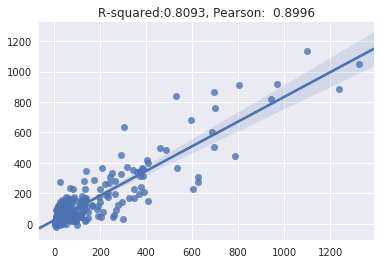

In [141]:
df_features = correlation_matrix_plot(
    dengue_season=False, 
    province=['10','80','81'], 
    norm=''
)

X = df_features.drop('cases', axis=1).values
y = df_features['cases'].values

X = df_features.loc[df.addrcode].drop('cases', axis=1).values
y = df_features.loc[df.addrcode]['cases'].values

X.shape, y.shape

predicted = model_selection.cross_val_predict(linear_model.LinearRegression(), X, y, cv=10)

_=plt.title('R-squared:' + str(round(metrics.r2_score(y, predicted),4)) + ', Pearson:  ' + str(np.round(pearsonr(y, predicted),4)[0]))
_=sns.set()
_=sns.regplot(y, predicted)

In [113]:
df_features.loc[df.addrcode].to_csv('/home/poom/Desktop/norm_features.csv')